In [1]:
from qiskit.transpiler import CouplingMap

coupling_map = CouplingMap.from_heavy_hex(3, bidirectional=False)

# Choose a 10-qubit linear chain on this coupling map
reduced_coupling_map = coupling_map.reduce([0, 13, 1, 14, 10, 16, 5, 12, 8, 18])

In [2]:
import numpy as np
from building_block_utils.problem_generators import generate_xyz_hamiltonian

# Get a qubit operator describing the Heisenberg XYZ model
hamiltonian = generate_xyz_hamiltonian(
    reduced_coupling_map,
    coupling_constants=(np.pi / 8, np.pi / 4, np.pi / 2),
    ext_magnetic_field=(np.pi / 3, np.pi / 6, np.pi / 9),
)
print(hamiltonian)

SparsePauliOp(['IIIIIIIXXI', 'IIIIIIIYYI', 'IIIIIIIZZI', 'IIIIIXXIII', 'IIIIIYYIII', 'IIIIIZZIII', 'IIIXXIIIII', 'IIIYYIIIII', 'IIIZZIIIII', 'IXXIIIIIII', 'IYYIIIIIII', 'IZZIIIIIII', 'IIIIIIIIXX', 'IIIIIIIIYY', 'IIIIIIIIZZ', 'IIIIIIXXII', 'IIIIIIYYII', 'IIIIIIZZII', 'IIIIXXIIII', 'IIIIYYIIII', 'IIIIZZIIII', 'IIXXIIIIII', 'IIYYIIIIII', 'IIZZIIIIII', 'XXIIIIIIII', 'YYIIIIIIII', 'ZZIIIIIIII', 'IIIIIIIIIX', 'IIIIIIIIIY', 'IIIIIIIIIZ', 'IIIIIIIIXI', 'IIIIIIIIYI', 'IIIIIIIIZI', 'IIIIIIIXII', 'IIIIIIIYII', 'IIIIIIIZII', 'IIIIIIXIII', 'IIIIIIYIII', 'IIIIIIZIII', 'IIIIIXIIII', 'IIIIIYIIII', 'IIIIIZIIII', 'IIIIXIIIII', 'IIIIYIIIII', 'IIIIZIIIII', 'IIIXIIIIII', 'IIIYIIIIII', 'IIIZIIIIII', 'IIXIIIIIII', 'IIYIIIIIII', 'IIZIIIIIII', 'IXIIIIIIII', 'IYIIIIIIII', 'IZIIIIIIII', 'XIIIIIIIII', 'YIIIIIIIII', 'ZIIIIIIIII'],
              coeffs=[0.39269908+0.j, 0.78539816+0.j, 1.57079633+0.j, 0.39269908+0.j,
 0.78539816+0.j, 1.57079633+0.j, 0.39269908+0.j, 0.78539816+0.j,
 1.57079633+0.j, 0.39269908+0.j, 0.

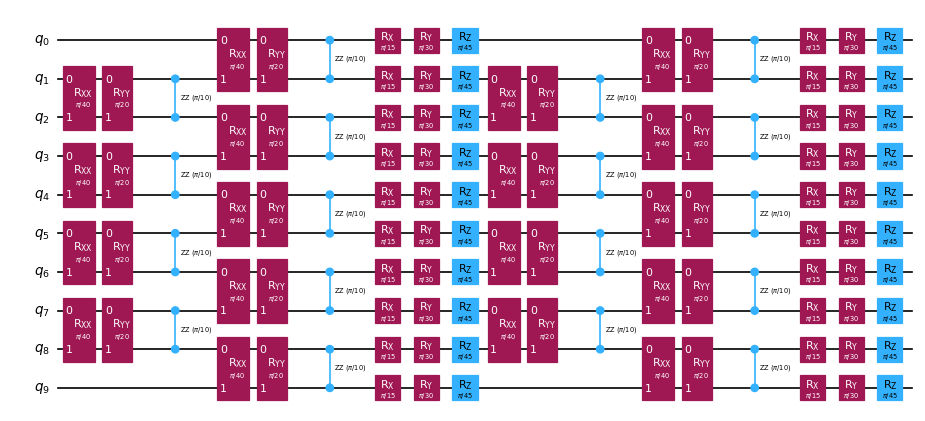

In [3]:
from building_block_utils.problem_generators import generate_time_evolution_circuit
from qiskit.synthesis import LieTrotter

circuit = generate_time_evolution_circuit(
    hamiltonian,
    time=0.2,
    synthesis=LieTrotter(reps=2),
)
circuit.draw("mpl", style="iqp", scale=0.6)

In [4]:
from qiskit_ibm_runtime import QiskitRuntimeService

# Initialize account.
service = QiskitRuntimeService()

In [5]:
from qiskit_ibm_runtime.fake_provider import FakeSherbrooke

backend = FakeSherbrooke()

In [6]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

pm = generate_preset_pass_manager(optimization_level=1, backend=backend)
isa_circuit = pm.run(circuit)

In [7]:
from povm_toolbox.library import ClassicalShadows

povm_implementation = ClassicalShadows(n_qubit=10)

In [8]:
from povm_toolbox.sampler import POVMSampler
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_ibm_runtime import Session

with Session(service=service, backend=backend) as session:
    # First define a standard sampler (that will be used under the hood).
    runtime_sampler = Sampler(session=session)
    # Then define the POVM sampler, which takes BaseSampler as an argument.
    povm_sampler = POVMSampler(runtime_sampler)
    # Submit the job by specifying which POVM to use, which circuit(s) to measure and the shot budget.
    job = povm_sampler.run(pubs=[isa_circuit], shots=128, povm=povm_implementation)
    result = job.result()

In [9]:
from povm_toolbox.post_processor import POVMPostprocessor

post_processor = POVMPostprocessor(result[0])

In [10]:
isa_observable = hamiltonian.apply_layout(isa_circuit.layout)
print(post_processor.get_expectation_value(hamiltonian))

8.964583724403681
